In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects
import geopandas as gpd
import numpy as np
import pandas as pd
from adjustText import adjust_text
plt.rcParams['font.family'] = 'DejaVu Sans Mono'#

In [5]:
def rhumbs(lon1, lat1, lon2, lat2):
    '''
    from http://www.movable-type.co.uk/scripts/latlong.html
    '''
    # Convert decimal degrees to radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    #### rhumb line calculations
    ###bearing
    if np.abs(dlon) > np.pi:
        if dlon > 0:
            dlon -= 2 * np.pi
        else:
            dlon += 2 * np.pi
    
    dpsi = np.log(
        np.tan(np.pi/4 + lat2/2) / np.tan(np.pi/4 + lat1/2)
    )
    theta = np.arctan2(dlon, dpsi)
    
    if theta < 0:
        theta += 2*np.pi
    
    # rhumb distance
    if np.abs(dlon)>1e-12:
        q = dlat/dpsi
    else:
        q = np.cos(lat1)
        
    d = np.sqrt(dlat**2 + ((q**2)*(dlon**2))) * 6371
    
    return d, np.rad2deg(theta)

In [6]:
w = gpd.read_file('ne_110m_populated_places.zip',
                  bbox=(-40,35,40,80),
                  where="ADM0CAP=1")

origin = w.loc[w['NAME']=='Budapest']
lon1 = origin['geometry'].x.values[0]
lat1 = origin['geometry'].y.values[0]

w = pd.concat(
    [w,
     (w['geometry'].apply(lambda q: rhumbs(lon1, lat1, q.x, q.y))
      .apply(pd.Series)
      .rename(columns={0:'rhumb_distance',
                       1:'rhumb_bearing'}))
     ], axis = 1)

In [7]:
cmap = plt.get_cmap('twilight')
norm = Normalize(vmin=0, vmax=360)
w['color'] = w['rhumb_bearing'].apply(lambda q:(cmap(norm(q))))

Text(0.09, 0.9, 'or: how to get from Budapest to other capital cities')

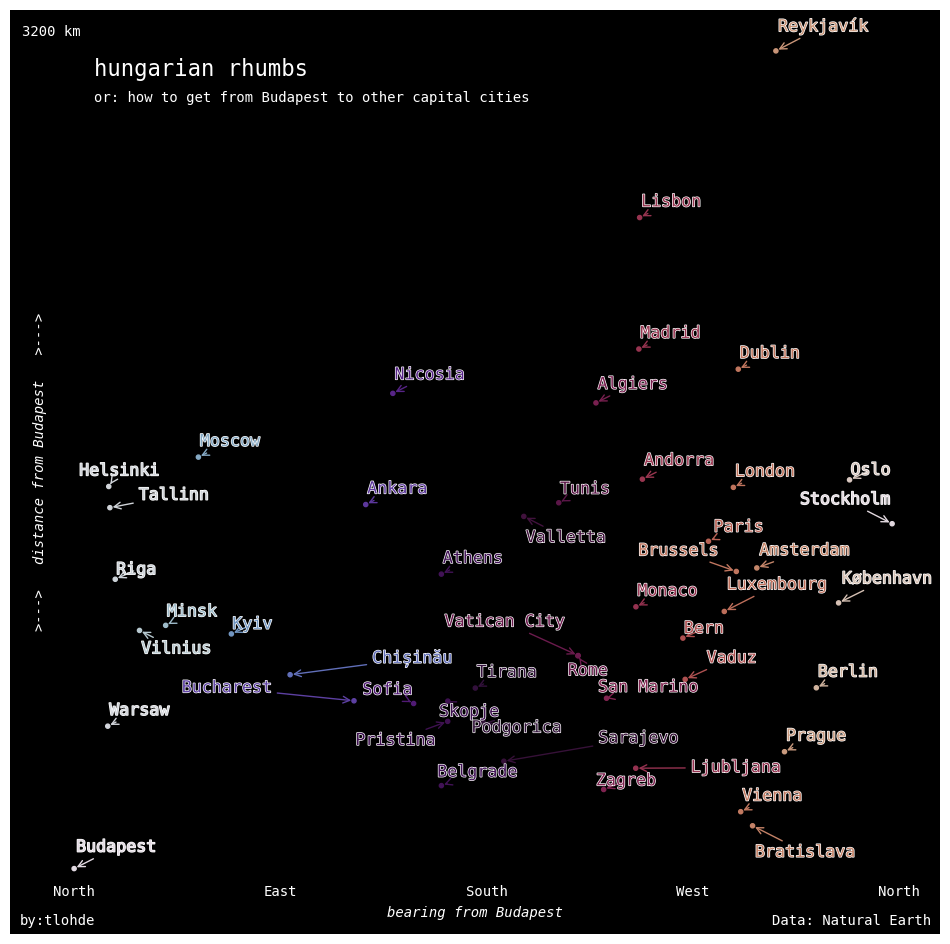

In [18]:
fig, ax = plt.subplots(figsize=[12,12])

ax.scatter(x=w['rhumb_bearing'],
           y=w['rhumb_distance'],
           marker='o', s=9,
           ec=w['color'],
           fc=w['color'])

texts=[]
for row in w.itertuples():
    text = ax.annotate(text = row.NAME,
                       xy=(row.rhumb_bearing, row.rhumb_distance),
                       xycoords='data',
                       ha='left',
                       va='bottom',
                       c=row.color,
                       fontsize=12,
                       arrowprops=dict(arrowstyle='->',
                                       edgecolor=row.color,
                                       ))
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'),
                           path_effects.Normal()])
    texts.append(text)    
adjust_text(texts)


ax.set_xlabel('bearing from Budapest', fontstyle='italic')
ax.set_xlim(-28,378)
ax.set_xticks([0,90,180,270,360],
              labels=['North','East','South','West','North'],
              ha='center')
ax.tick_params(axis='x',
               which='both',
               pad=-35,
               length=0,
               colors='w')
ax.xaxis.label.set_color('w')
ax.xaxis.set_label_coords(0.5,0.03)

ax.set_ylabel('>--->   distance from Budapest   >--->', fontstyle='italic')
ax.set_ylim(w['rhumb_distance'].max()*-0.08,
            w['rhumb_distance'].max()*1.05)
ax.set_yticks([3200], labels=['3200 km'], ha='center')
ax.tick_params(axis='y',
               which='both',
               pad=-30,
               length=0,
               colors='w')
ax.yaxis.label.set_color('w')
ax.yaxis.set_label_coords(0.04,0.5)

ax.set_facecolor('k')
_=[ax.spines[var].set_visible(False) for var in ['left','right','top','bottom']]

ax.annotate(text='Data: Natural Earth',
            xy=(0.99,0.01), 
            xycoords='axes fraction', 
            ha='right',
            c='w', 
            fontsize=10)

ax.annotate(text='by:tlohde',
            xy=(0.01,0.01), 
            xycoords='axes fraction',
            ha='left',
            fontsize=10,
            c='w')

ax.set_title('hungarian rhumbs',
             x=0.09,y=0.92,
             c='w',size=16,ha='left')

ax.annotate('or: how to get from Budapest to other capital cities',
            xy=(0.09,0.9),
            xycoords='axes fraction',
            fontsize=10,c='w')

# fig.savefig('day28.png', dpi=300, bbox_inches='tight')